## Step 1: Basic Function

In [1]:
!pip install seaborn
import wandb
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://bytedpypi.byted.org/simple/


In [2]:
def extract_results(project_name, run_ids, column_names):
    """
    Extract metrics data from multiple Weights & Biases runs.
    
    Args:
        project_name: The name of the WandB project
        run_ids: Single run ID string or list of run ID strings
        column_names: list of column names to extract
        
    Returns:
        A pandas DataFrame containing the concatenated results

    """
    assert isinstance(run_ids, (str, list))
    if isinstance(run_ids, str):
        run_ids = [run_ids]               
    result_list = []

    for id in run_ids:
        api = wandb.TrackingApi()        
        run = api.run(project=project_name, run_id=id)
        h = run.history(name=column_names)
        result_list.append(pd.DataFrame(h))
    concat_result = pd.concat(result_list, ignore_index=True)
    
    return concat_result

In [3]:
# default plot parameters
ax_label_font = 12
tick_label_font = 10
legend_font = 12
line_width = 2
marker_size = 5
grid_alpha = 0.5
step_magnitude = 1e3
fig_height = 6
fig_aspect = 1.5
dpi = 300
colors_list = [
        '#FF4B4B',  # Red (vibrant)
        '#4B7BFF',  # Blue (vibrant)
        '#4CAF50',  # Green (vibrant)
        '#9D4EDD',  # Purple
        '#FF9F1C',  # Orange
        '#FFD166',  # Yellow
        '#06D6A0',  # Teal
        '#118AB2',  # Cyan
        '#073B4C',  # Dark blue
        '#F15BB5',  # Pink
    ]


def plot_results(results_dict, 
                 show_plt_style=False,
                 ax_label_font=ax_label_font,
                 tick_label_font=tick_label_font,
                 legend_font=legend_font,
                 line_width=line_width,
                 marker_size=marker_size,
                 grid_alpha=grid_alpha,
                 step_magnitude=step_magnitude,
                 fig_height=fig_height,
                 fig_aspect=fig_aspect,
                 dpi=dpi,
                 style_name='seaborn-whitegrid',
                 x_limits=None,
                 y_limits=None,         
                 x_plot_sample=1,  # control sampling rate   
                 colors_list=colors_list,
                 save_path=None):  # Add save_path parameter
    # Apply style
    plt.style.use(style_name)
        
    # Extract column names from the first DataFrame in results_dict
    if results_dict:
        first_key = list(results_dict.keys())[0]
        column_names = list(results_dict[first_key].columns)
        # Remove 'step' from the column names since it's the x-axis
        column_names.remove('step')
    num_columns = len(column_names)
    # Set up the figure and axes
    fig, axes = plt.subplots(1, num_columns, figsize=(num_columns*fig_height*fig_aspect, fig_height), dpi=dpi)
    
    # Ensure axes is always an array even if there's only one subplot
    if num_columns == 1:
        axes = [axes]
    # Plot results for each column
    for col_idx, column in enumerate(column_names):
        ax = axes[col_idx]
        for i, (method, df) in enumerate(results_dict.items()):
            sampled_df = df.iloc[::x_plot_sample]            
            color = colors_list[i % len(colors_list)]            
            ax.plot(sampled_df['step'], sampled_df[column], label=method, marker='o', linestyle='-', 
                    linewidth=line_width, markersize=marker_size, color=color)
        # ax.set_title(column, fontsize=14)
        ax.set_xlabel('Steps ', fontsize=ax_label_font)
        ax.set_ylabel(column, fontsize=ax_label_font)
        ax.legend(loc="best", fontsize=legend_font)
        ax.grid(True, alpha=grid_alpha)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{x/step_magnitude:.0f}"))
        ax.tick_params(axis='both', which='major', labelsize=tick_label_font)
        ax.set_xlabel(f"Steps (×{step_magnitude:.0e})".replace("+0", ""))

        # Set x-limits if provided
        if x_limits is not None:
            ax.set_xlim(x_limits)

        if y_limits is not None:
            ax.set_ylim(y_limits)                  
        
    # Adjust layout and show the plot
    if show_plt_style:
        plt.suptitle(f'Plot Style: {style}', fontsize=16)
    plt.tight_layout()
    
    # Save the figure if save_path is provided
    if save_path:
        os.makedirs("figures", exist_ok=True)
        # Save as PDF
        pdf_path = f"figures/{save_path}.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        
        # Save as JPG
        jpg_path = f"figures/{save_path}.jpg"
        fig.savefig(jpg_path, format='jpg', bbox_inches='tight', dpi=300)
        
        print(f"Figure saved to {pdf_path} and {jpg_path}")
    
    plt.show()

## Step 2: Plot for mix-resolution training
https://ml.bytedance.net/experiment/tracking/detail?Id=project_20240805_8d893055&tab=CHART&viewId=view_20241009_1b4085cf

Figure saved to figures/mix_training_seaborn-v0_8-whitegrid.pdf and figures/mix_training_seaborn-v0_8-whitegrid.jpg


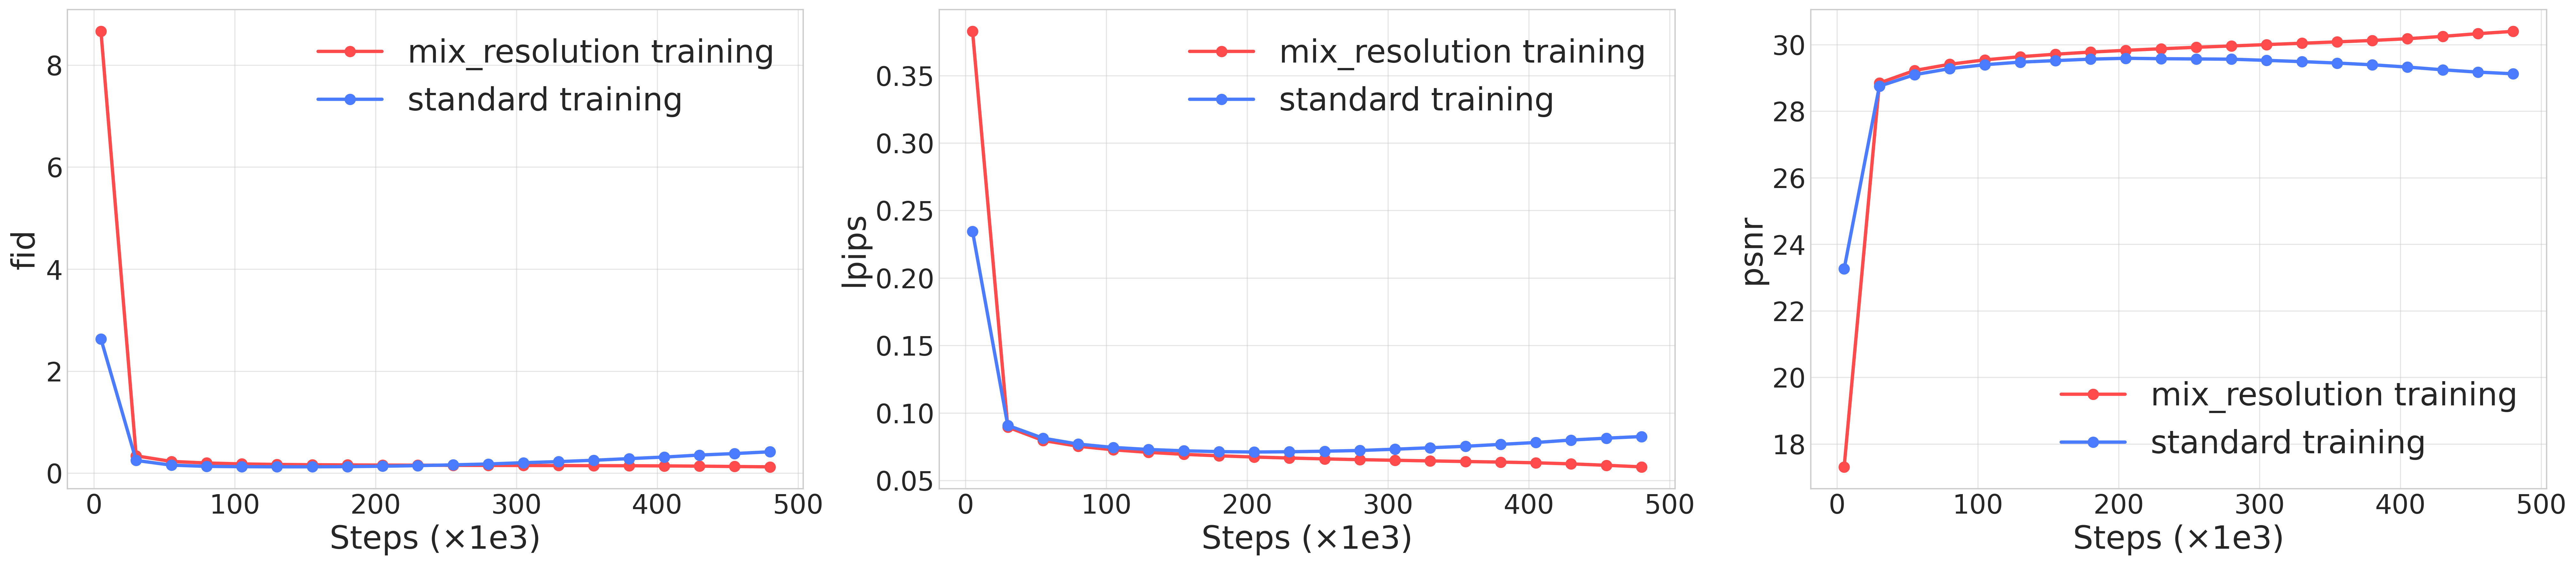

In [4]:
methods = ["mix_resolution training", "standard training"]
project_names = ["image_vae_v3", "scan_video_vae"]
id_lists = [["run_20241004_8e8c51d5", "run_20241004_33455ac4"], "16x_ch48_coco_2017_at_512"]

results_dict = {}
for idx, method in enumerate(methods):
    results_dict[method] = extract_results(
        project_name=project_names[idx], 
        run_ids=id_lists[idx], 
        column_names=["fid", "psnr", "lpips"])

# Example usage:
font_scale = 2
fig_name = "mix_training"
for style in plt.style.available:
    if "whitegrid" in style:
        plot_results(results_dict,  style_name=style, show_plt_style=False, 
                     ax_label_font=ax_label_font*font_scale,
                     tick_label_font=tick_label_font*font_scale,
                     legend_font=legend_font*font_scale,
                     marker_size=marker_size*1.5,
                     line_width=line_width*1.25,   
                     x_plot_sample=5,
                    save_path=f"{fig_name}_{style}")

## Step 3: Dual-stream
https://ml.byteintl.net/experiment/tracking/detail?Id=project_20241010_9150002a&tab=TABLE&viewId=view_20241030_07b75aa8


Figure saved to figures/dual_stream_seaborn-v0_8-whitegrid.pdf and figures/dual_stream_seaborn-v0_8-whitegrid.jpg


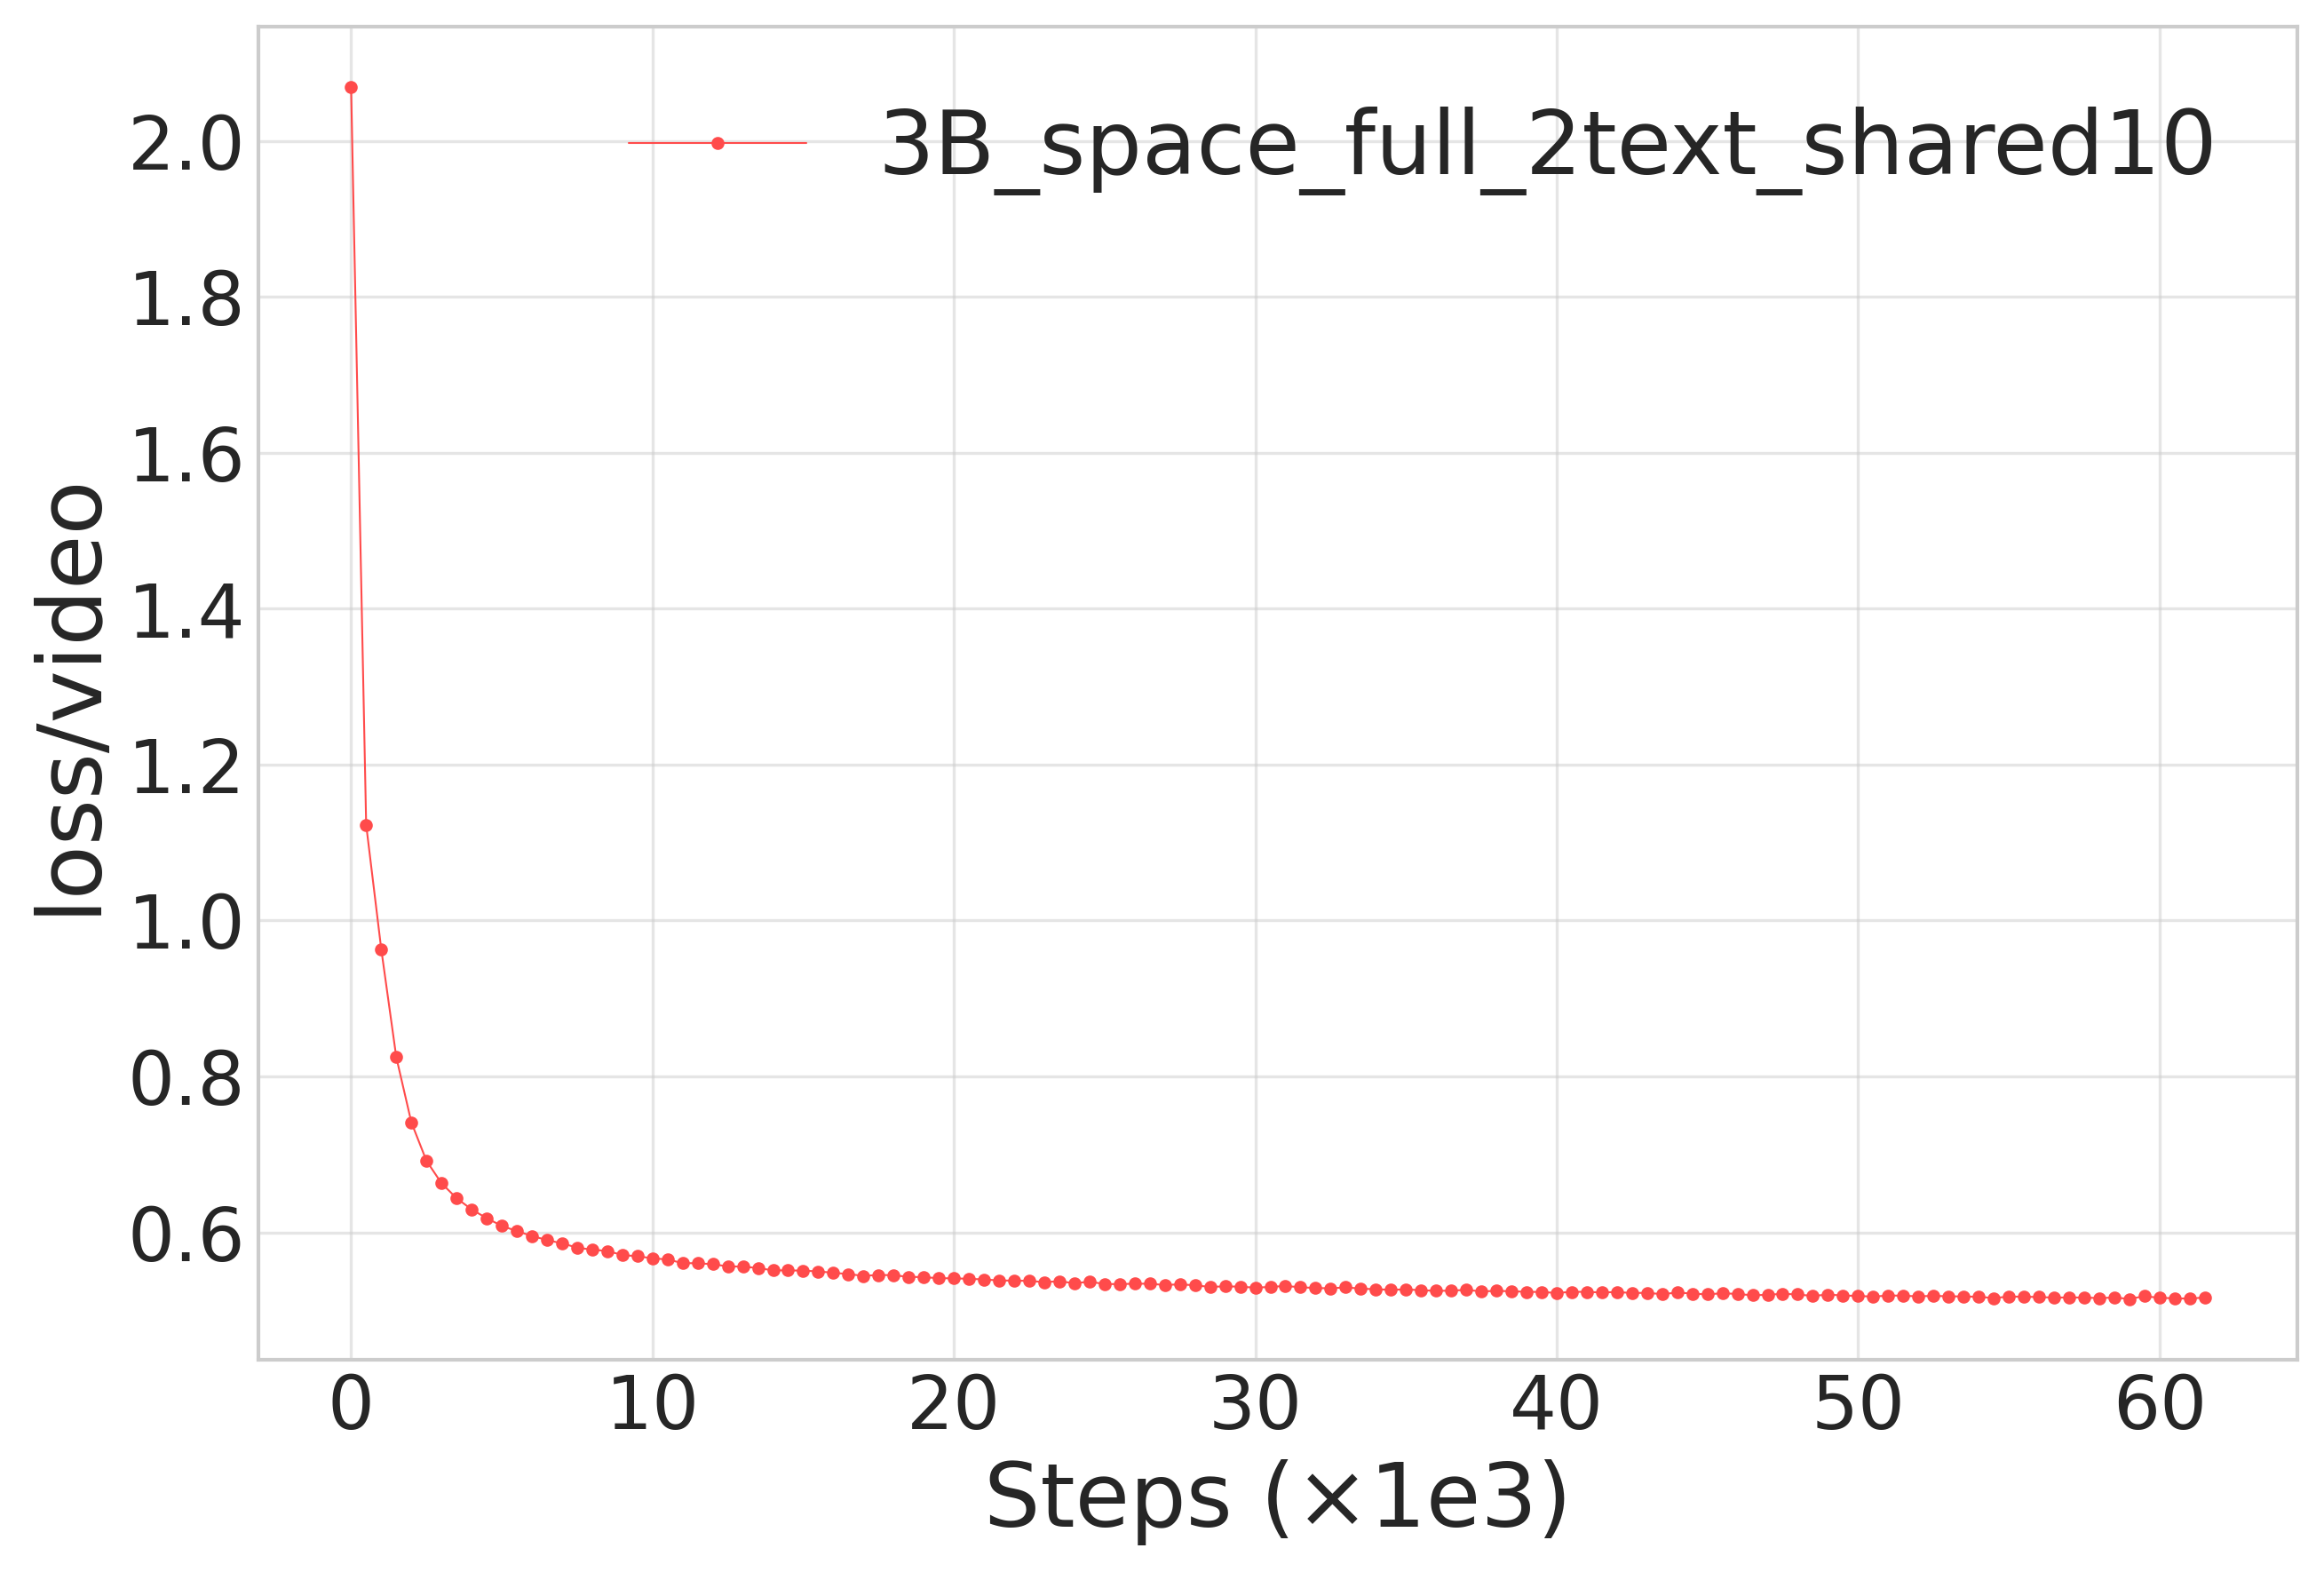

In [6]:
# extract results for mix-resolution training
project_names = ["damn", "damn", "damn"]
# the last two lies at i18n
# id_lists = ["3B_space_full_2text_shared10", "3B_space_full_2text_noshared", "3B_space_full_2text_shared10_3Bparam"]
id_lists = [ "3B_space_full_2text_shared10"]
methods = id_lists

results_dict = {}
for idx, method in enumerate(methods):
    results_dict[method] = extract_results(
        project_name=project_names[idx], 
        run_ids=id_lists[idx], 
        column_names=["loss/video"])
    # print(results_dict)

# Example usage:
font_scale = 2
fig_name = "dual_stream"
for style in plt.style.available:
    if "whitegrid" in style:
        plot_results(results_dict,  style_name=style, show_plt_style=False, 
                     ax_label_font=ax_label_font*font_scale,
                     tick_label_font=tick_label_font*font_scale,
                     legend_font=legend_font*font_scale,
                     marker_size=marker_size*0.5,
                     line_width=line_width*0.25,       
                     x_plot_sample=5,
                    save_path=f"{fig_name}_{style}")

## Step 4 Atten loss
https://ml.bytedance.net/experiment/tracking/detail?Id=project_20241015_5d38c127&tab=TABLE&selectedTrial=&viewId=view_20250313_e6246169


Figure saved to figures/attn_loss_seaborn-v0_8-whitegrid.pdf and figures/attn_loss_seaborn-v0_8-whitegrid.jpg


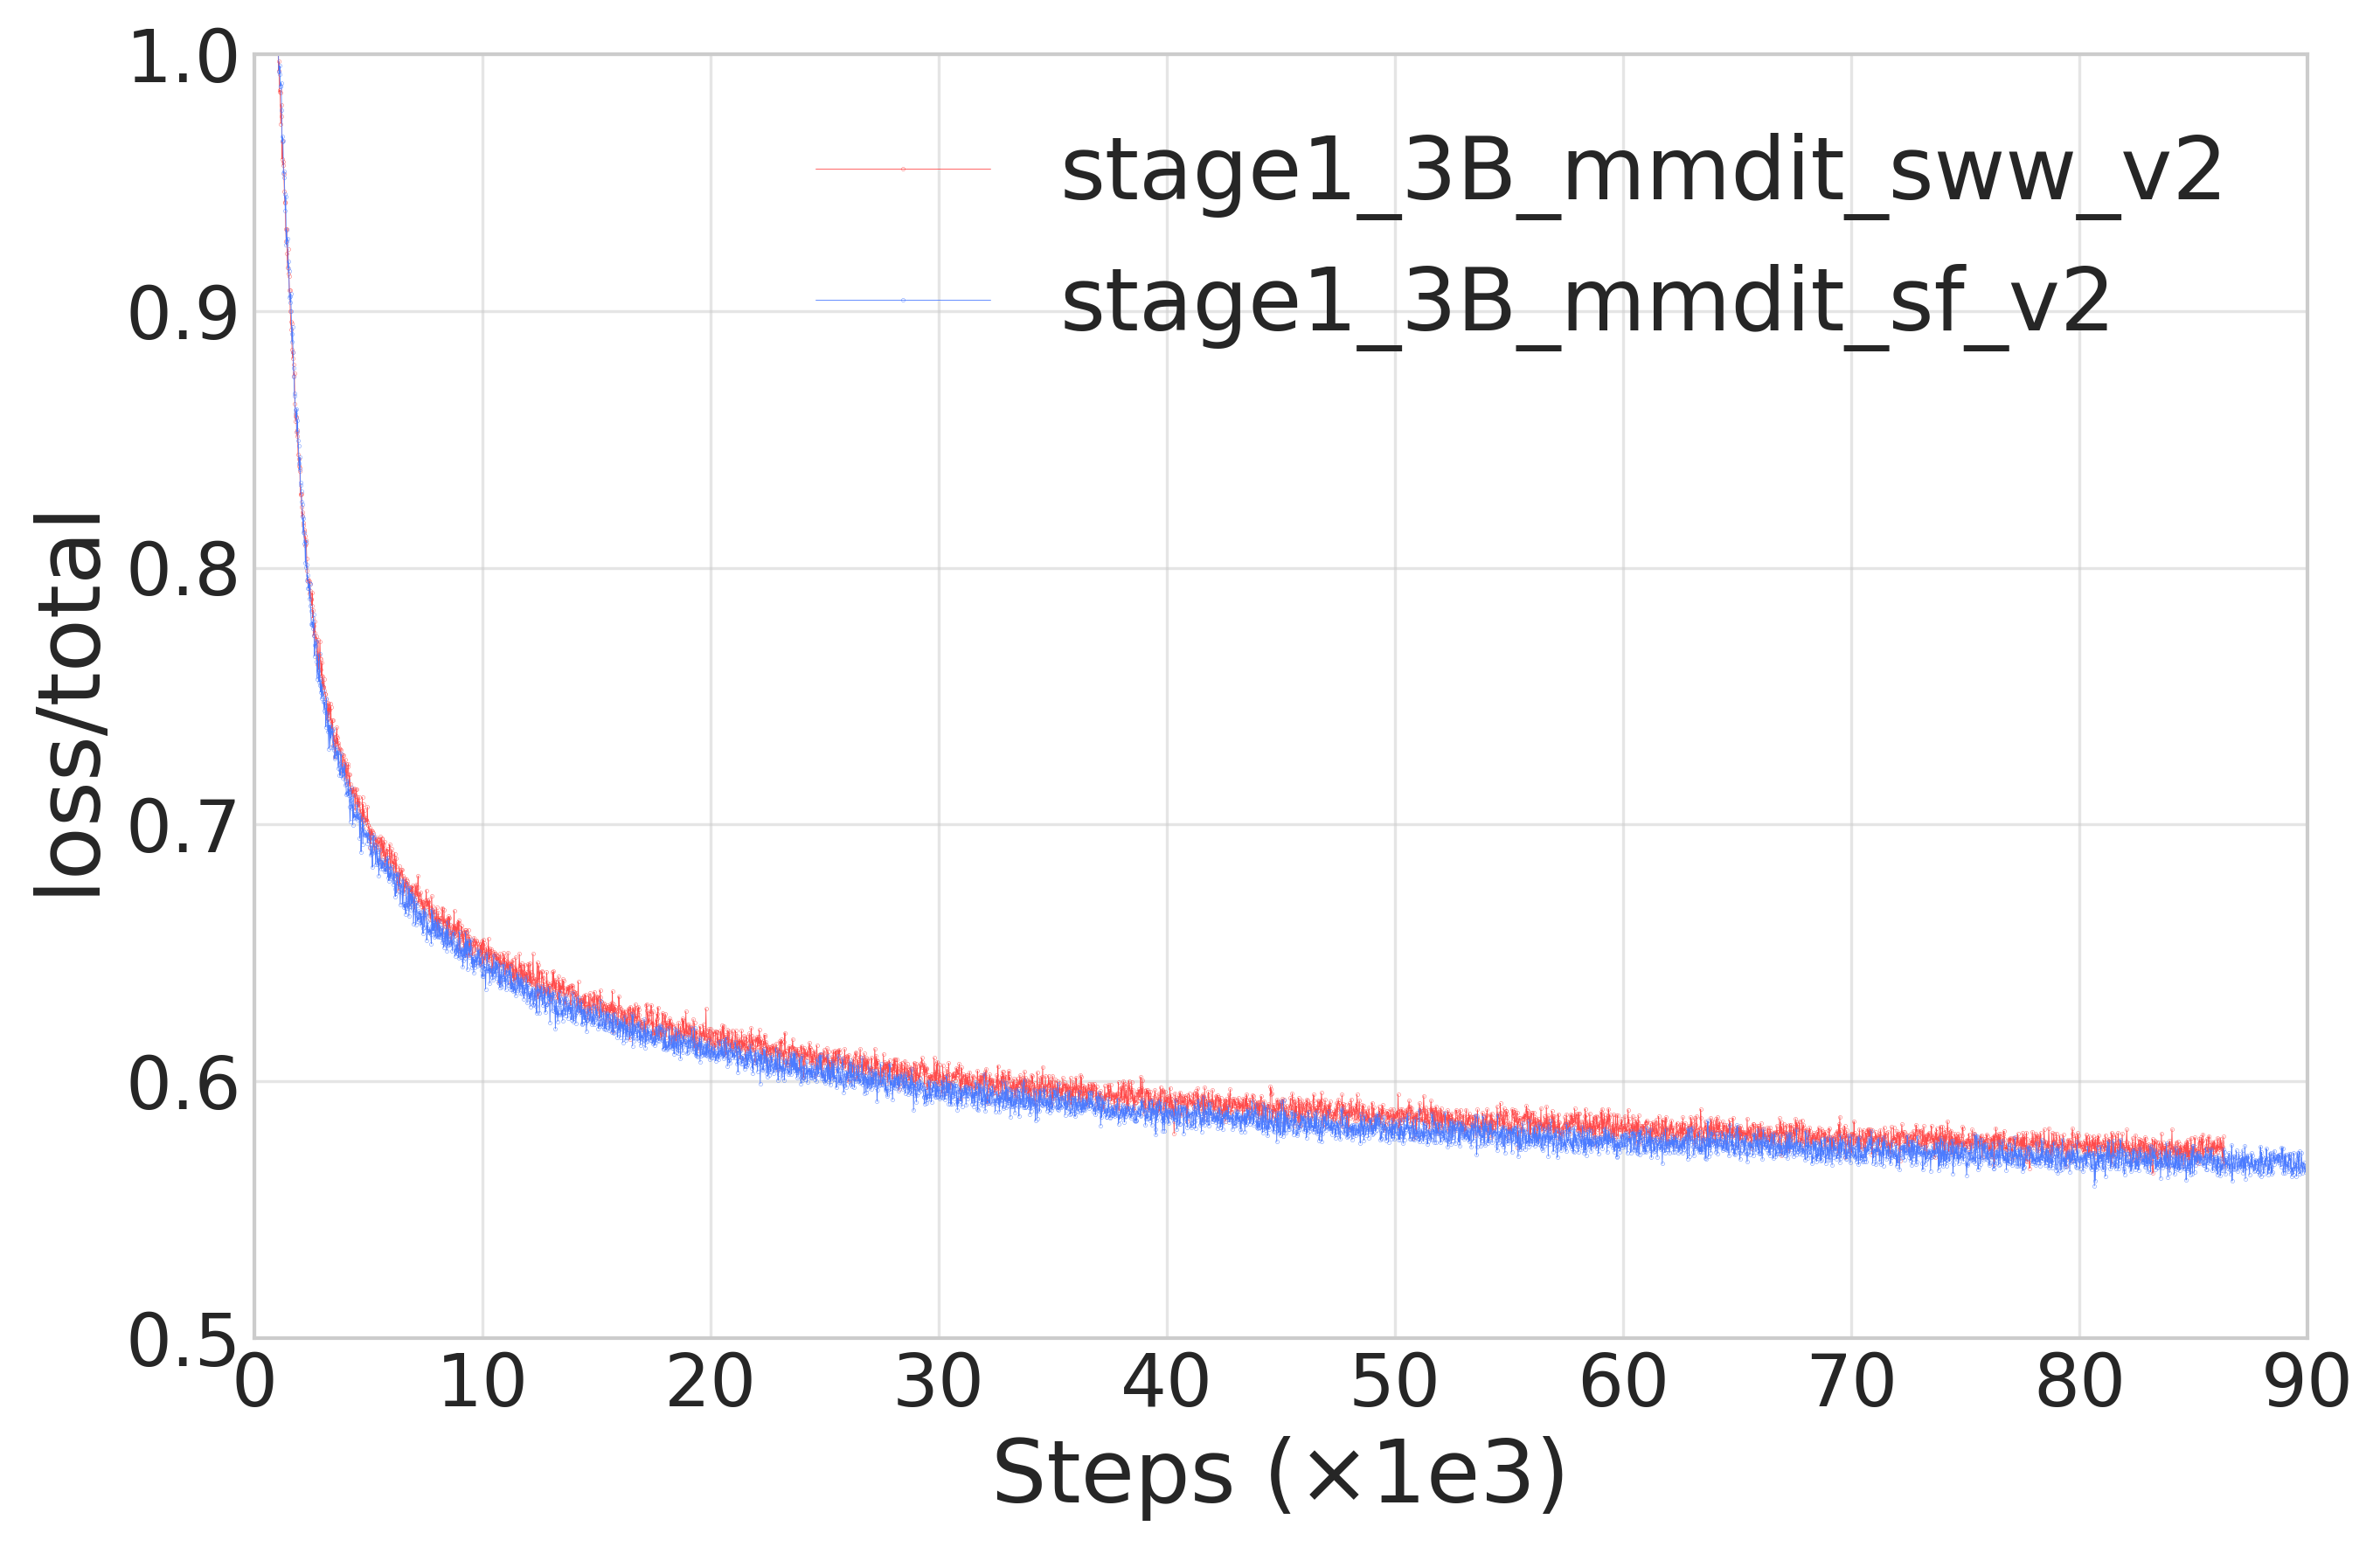

In [17]:
# extract results for mix-resolution training
project_names = ["xf.dit_attn3", "xf.dit_attn3",]
id_lists = [ "run_20241015_4642b927", "run_20241015_29414963"]
methods = ["stage1_3B_mmdit_sww_v2", "stage1_3B_mmdit_sf_v2"]

results_dict = {}
for idx, method in enumerate(methods):
    results_dict[method] = extract_results(
        project_name=project_names[idx], 
        run_ids=id_lists[idx], 
        column_names=["loss/total"])
# print(results_dict)

# Example usage:
font_scale = 2
fig_name = "attn_loss"
for style in plt.style.available:
    if "whitegrid" in style:
        plot_results(results_dict,  style_name=style, show_plt_style=False, 
                     ax_label_font=ax_label_font*font_scale,
                     tick_label_font=tick_label_font*font_scale,
                     legend_font=legend_font*font_scale,
                     marker_size=marker_size*0.02,
                     line_width=line_width*0.1,
                     x_limits=[0, 9e4],
                     y_limits=[0.5,1],
                     x_plot_sample=1,
                    save_path=f"{fig_name}_{style}")

## Step 5: MMRope
https://ml.bytedance.net/experiment/tracking/detail?Id=project_20241026_08d8d6fb&tab=TABLE&viewId=view_20241030_1030dbf4

Figure saved to figures/mmrope_seaborn-v0_8-whitegrid.pdf and figures/mmrope_seaborn-v0_8-whitegrid.jpg


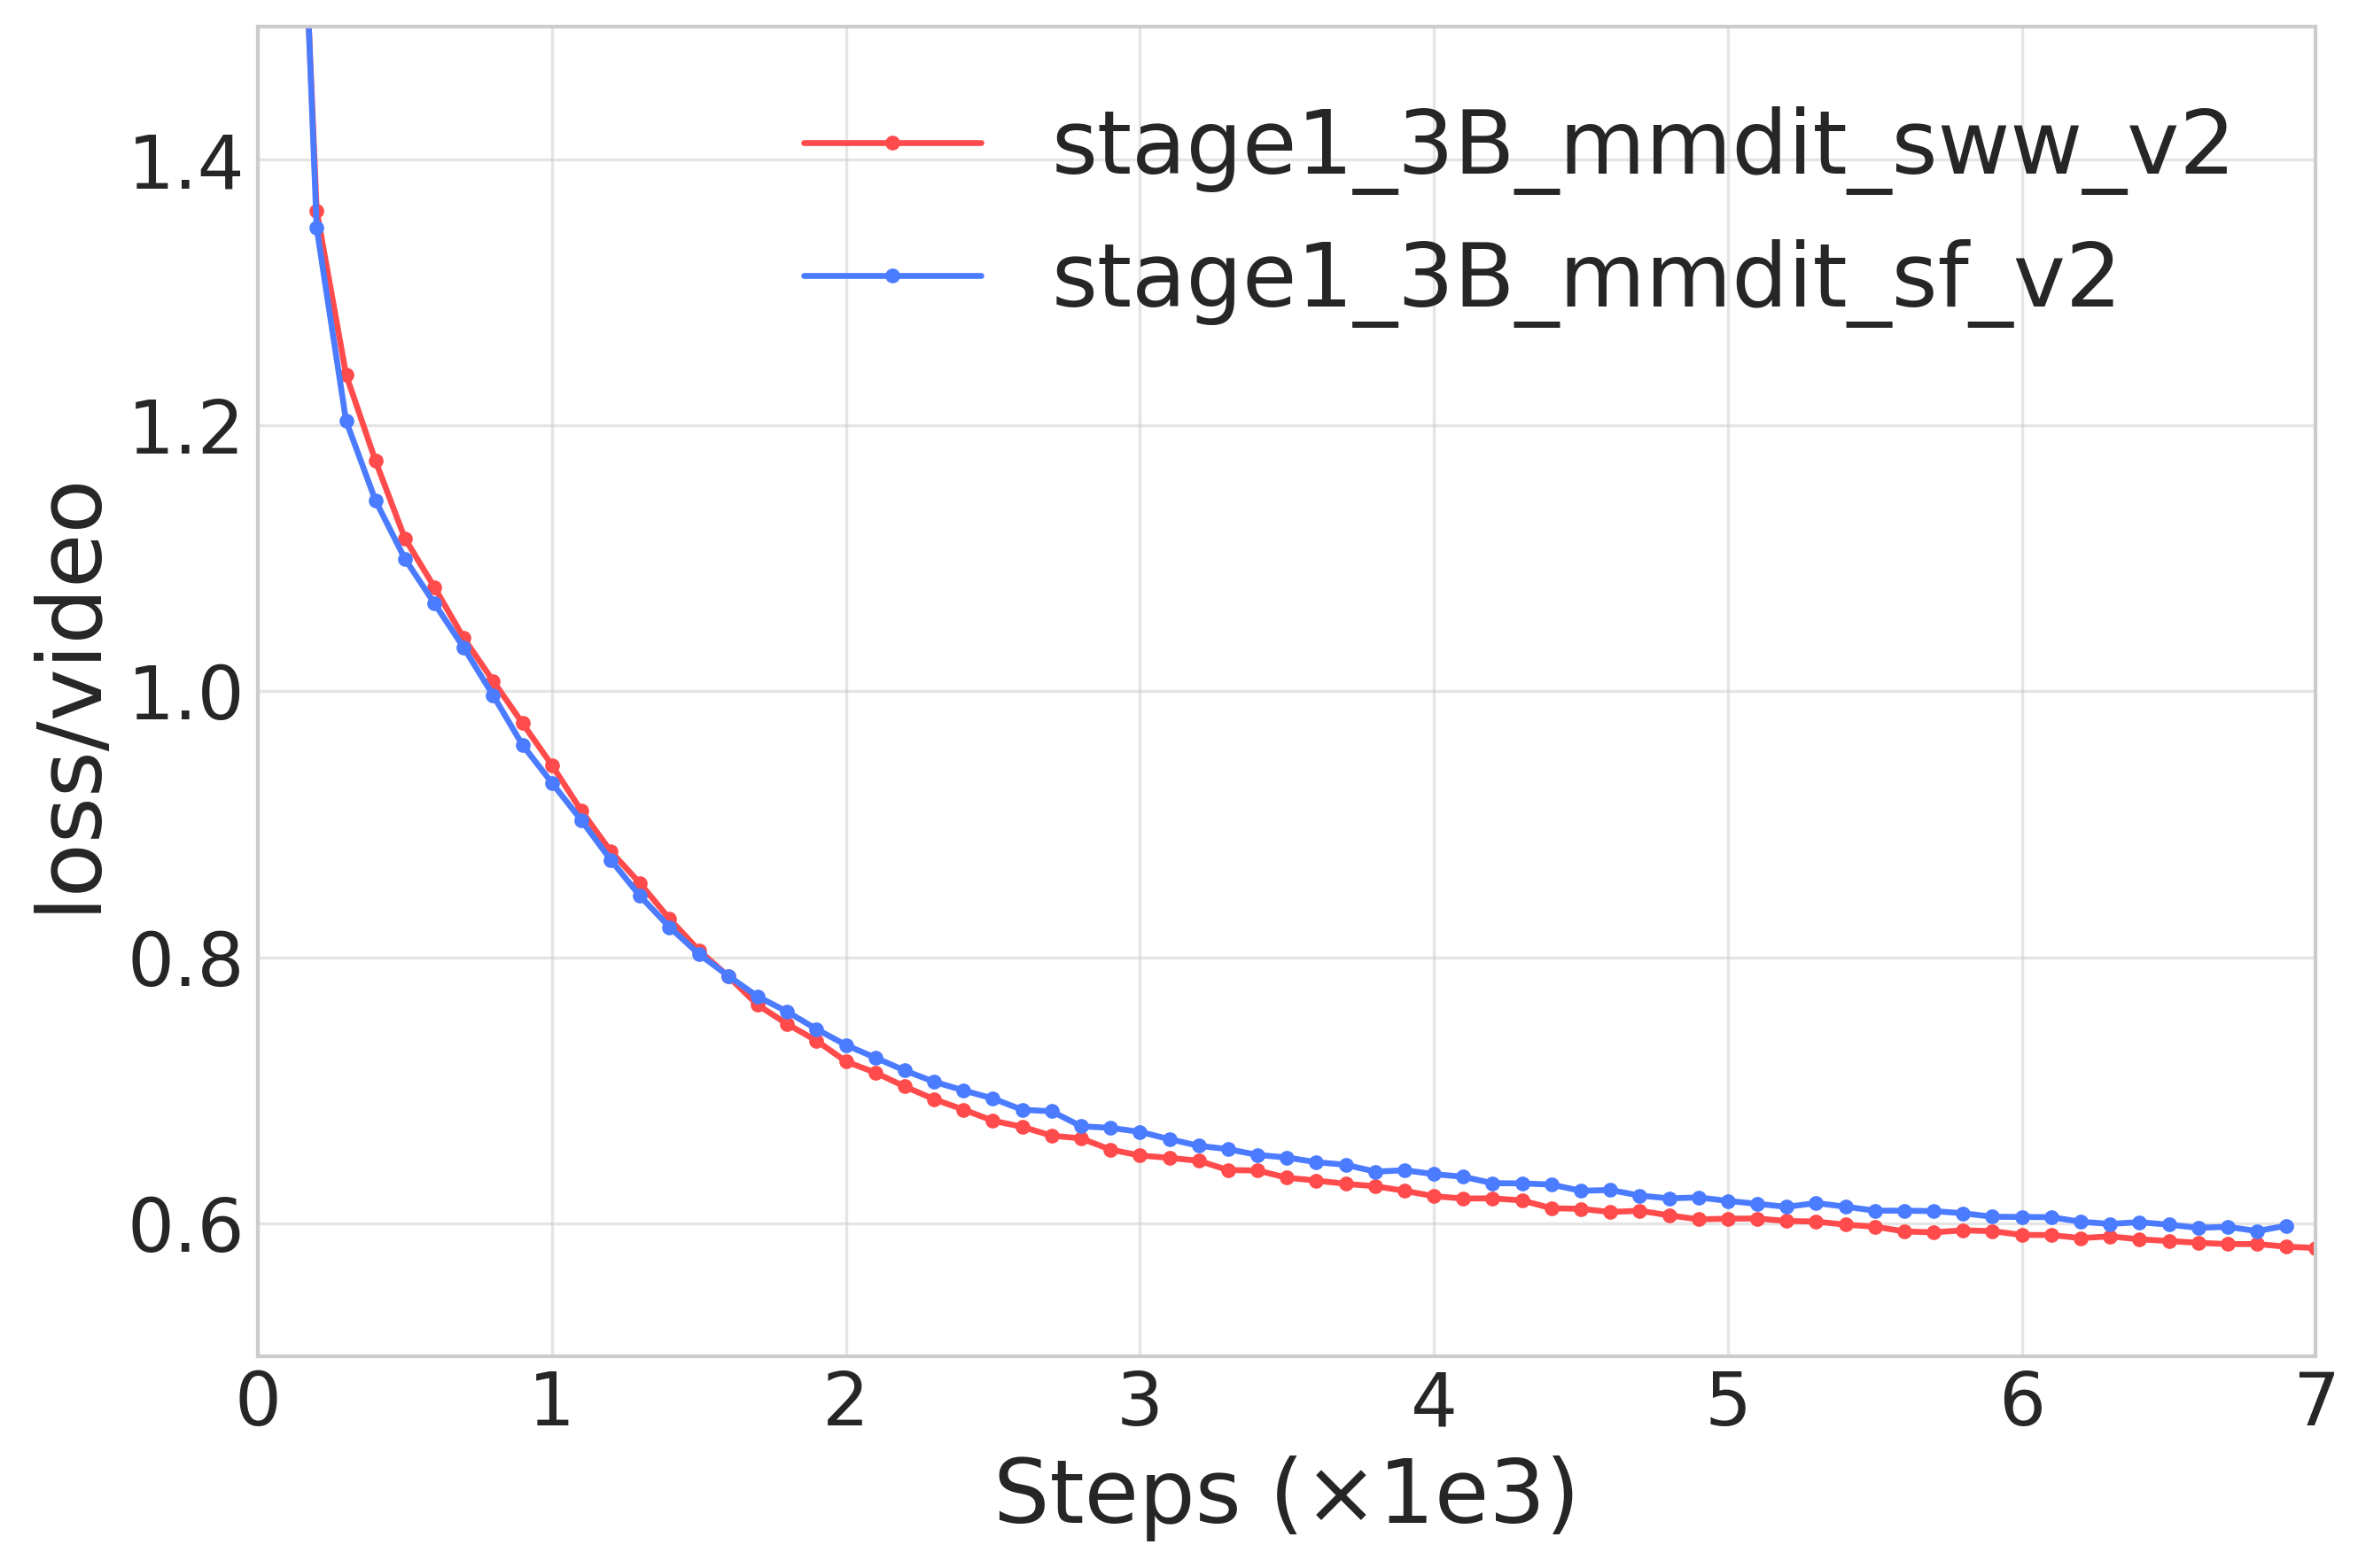

In [12]:
project_names = ["pre_preview", "pre_preview"]
id_lists = [ "3B_full_mmrope3d_final", "3B_full_rope3d"] 
id_lists = ["3B_full_mmrope3d_final", "3B_full_mmrope3d_2"]

results_dict = {}
for idx, method in enumerate(methods):
    results_dict[method] = extract_results(
        project_name=project_names[idx], 
        run_ids=id_lists[idx], 
        column_names=["loss/video"])
# print(results_dict)

# Example usage:
font_scale = 2
fig_name = "mmrope"
for style in plt.style.available:
    if "whitegrid" in style:
        plot_results(results_dict,  style_name=style, show_plt_style=False, 
                     ax_label_font=ax_label_font*font_scale,
                     tick_label_font=tick_label_font*font_scale,
                     legend_font=legend_font*font_scale,
                     marker_size=marker_size*0.6,
                     line_width=line_width*0.8,
                     x_limits=[0,7e3],
                     y_limits=[0.5, 1.5],
                     x_plot_sample=1,
                    save_path=f"{fig_name}_{style}")